# E-media decodowanie formatu PNG

In [28]:
import zlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np

In [30]:
path = "test.png"
file = open(path, "rb")

## Weryfikacja sygnatury

#### Pierwsze 8 byte'ow pliku PNG zawiera sygnature fromatu Sygnatura PNG `137 80 78 71 13 10 26 10`

In [31]:
def verifySignature(file):
    signature = file.read(8)
    if signature != bytes([137, 80, 78, 71, 13, 10, 26, 10]):
        print("Invalid PNG file")
        return False
    return True
verifySignature(file)

True

## Chunki

##### Długość

- 4-bajtowa liczba całkowita bez znaku podająca liczbę bajtów w polu danych fragmentu. Długość obejmuje tylko pole danych, a nie samo pole.

##### Typ Chunku

- Kod typu fragmentu 4-bajtowego. Dla wygody opisu i badania plików PNG, kody typu są ograniczone do wielkich i małych liter ASCII (A-Z i a-z lub 65-90 i 97-122 w systemie dziesiętnym).

##### Zawartość chunku

- Bajty danych odpowiednie dla typu fragmentu, jeśli takie istnieją. To pole może mieć długość zerową.

##### CRC
- 4-bajtowy CRC (Cyclic Redundancy Check). Wykrywa błędy w przesyłanych lub przechowywanych danych. Sprawdza czy dane nie zostały uszkodzone podczas transmisji lub zapisu.

In [32]:
class Chunk:
    def __init__(self, length, type, data, crc):
        self.length = length
        self.type = type
        self.data = data
        self.crc = crc

    def __str__(self):
        return f"Chunk(type={self.type}, length={self.length})"

## Odczyt chunków

In [33]:
def read_chunks(file):
    chunks = [] # pusta lista w której przechowywane są odczytane chunki
    while True:
        length_bytes = file.read(4)

        length = int.from_bytes(length_bytes, 'big') # konwertujemy odczytane bajty na liczbę całkowitą
        type = file.read(4).decode('utf-8') # odczyt typu poprzez zdekodowanie 4 bajtów z formatu UTF-8
        data = file.read(length) # odczyt danych
        crc = file.read(4)

        chunk = Chunk(length, type, data, crc) # obiekt klasy Chunk przechowuje odczytane dane 
        chunks.append(chunk) #obiekt chunk dodajemy do listy chunks
        print(chunk)
        if type == "IEND":
            break
    return chunks # zwrocenie listy chunkow
chunks = read_chunks(file)

Chunk(type=IHDR, length=13)
Chunk(type=IDAT, length=4572)
Chunk(type=IEND, length=0)


## Chunki krytyczne

#### `IHDR` (Image Header) oraz `IEND`
Fragmenty mogą pojawiać się w dowolnej kolejności, z zastrzeżeniem ograniczeń nałożonych na każdy typ fragmentu. Jednym z ważniejszych ograniczeń jest to, że `IHDR` musi pojawić się jako pierwszy, a `IEND` jako ostatni

In [34]:
def decode_IHDR(chunk):
    if chunk.type != "IHDR":
        raise ValueError("Chunk is not IHDR")
    
    image_info = {
        "width": int.from_bytes(chunk.data[0:4], 'big'), # szerokosc obrazu 
        "height": int.from_bytes(chunk.data[4:8], 'big'), # wysokosc obrazu
        "bit_depth": chunk.data[8], # głębia bitowa 
        "color_type": chunk.data[9], # typ koloru
        "compression_method": chunk.data[10], # metoda kompresji tylko 0 (deflate zlib)
        "filter_method": chunk.data[11], # metoda filtrowania
        "interlace_method": chunk.data[12] # metoda przeplatania
    }
    return image_info

IHDR = decode_IHDR(chunks[0])
print(IHDR)

{'width': 347, 'height': 347, 'bit_depth': 8, 'color_type': 6, 'compression_method': 0, 'filter_method': 0, 'interlace_method': 0}


In [35]:
def decode_IDAT(chunks):
    compressed_data = b'' # pusty najtowy ciąg
    
    for chunk in chunks:
        if chunk.type == "IDAT":
            compressed_data += chunk.data
    try:
        decompressed_data = zlib.decompress(compressed_data) # dekompresja danych 
        return decompressed_data
    except zlib.error as e:
        return None # jezeli dekompresja sie nie powiedzie
    
def decode_scanlines(decompressed_data, width, height):
    scanlines = []
    byte_index = 0
    for _ in range(height):
        # Bit separujacy każda linie
        byte_index += 1
        
        row_pixels = []
        for _ in range(width): # kolory RGB jednen pixel
            r = decompressed_data[byte_index]
            g = decompressed_data[byte_index + 1]
            b = decompressed_data[byte_index + 2]
            row_pixels.append((r, g, b))
            byte_index += 3
        scanlines.append(row_pixels)
    
    return scanlines

### PLTE Palette

- Header `PLTE` jest opcjonalny, chyba ze bajt typu coloru jest ustawiony na PLTE (3)
- Header `PLTE` zawiera palete kolorów które sa używane przez obraz PNG
- Każdy piksel w obrazie mapuje sie na jeden z kolorów w palecie zamiast bezpośrednio przechowywać wartosci `RGB` (kompresja)

# Todo zwizualizowac palete graficznie

In [36]:
def decode_PLTE(chunk):
    if chunk.type != "PLTE":
        raise ValueError("Not a PLTE chunk")
    
    palette = [] # lista do której beda dodawane kolory
    for i in range(0, len(chunk.data), 3):
        r = chunk.data[i] # czerwony 
        g = chunk.data[i+1] # zielony 
        b = chunk.data[i+2] # niebieski
        palette.append((r, g, b))
    
    return palette # zwracamy cala liste RGB

def show_color_palette(path):

    image = Image.open(path)

    if image.mode != 'P':
        print("This image does not use a color palette")
        return

    # pobieranie palety jako lista liczb [0 - 255]
    raw_palette = image.getpalette()

    # zapisanie koloru w postaci listy (R, G, B)
    palette = []
    for i in range(0, len(raw_palette), 3):
        color = tuple(raw_palette[i:i+3])
        if color != (0, 0, 0):  # nie uwzględniam carnego koloru 
            palette.append(color)

    # Wypisanie koloru
    print("Color Palette:")
    for index, color in enumerate(palette):
        print(f"{index}: RGB{color}")

# Example usage
show_color_palette("sample_with_PLTE.png")

Color Palette:
0: RGB(255, 0, 0)
1: RGB(0, 255, 0)
2: RGB(0, 0, 255)
3: RGB(255, 255, 0)
4: RGB(255, 0, 255)
5: RGB(0, 255, 255)
6: RGB(128, 0, 0)
7: RGB(0, 128, 0)
8: RGB(0, 0, 128)
9: RGB(128, 128, 0)
10: RGB(128, 0, 128)
11: RGB(0, 128, 128)
12: RGB(192, 192, 192)
13: RGB(128, 128, 128)
14: RGB(64, 64, 64)


## Ancillary chunks

- Wszystkie dodatkowe fragmenty są `opcjonalne`,
- Fragmenty opcjonalne zaczynaja sie od `małych liter`

---

### tEXt
- pozwala osadzić prosty tekst `ASCII` w pliku
- brak kompresji

---

### zTXt
- pozwala osadzić prosty tekst `ASCII` w pliku
- zkompresowany `zlib'em`

#### Struktura zTXt :
Pole | Typ  | opis
--- | ---  | ---
keyword | ASCII | nagłówek
nullseparator | 1 bajt  |
typ kompresji | 1 bajt | 0/1 zlib/deflate
zkompresowany tekst | reszta bajtów |

---

### iTXt
- pozwala zapisać tekst w formacie `UTF-8`
- opcjonalna kompresja

##### Struktura iTXt :
Pole | Typ  | opis
--- | ---  | ---
keyword | ASCII | nagłówek
flaga kompresji | 1 bajt  | 0/1 nie/tak
typ kompresji | 1 bajt | 0 zlib/deflate 1 niedozwolone
jezyk | ASCII | "en" "pl"
keyword w utf-8| UTF-8
zkompresowany tekst | UTF-8 | reszta bajtów 

---

### tIME

- służy do przechowywania ostatniej edycji pliku

rozmiar (bajty) |  opis
--- | ---  
2 | rok
1 | miesiac
1 | dzien
1 | godzina
1 | minuta
1 | sekunda

---

### bKGD

- struktura nagłowka `bKGB` jest zależna od pola bajtów `Color type` z IHDR'a

Color type pliku | opis  | dane w `bKGB`
--- | ---  | ---
0 | Grayscale | 2bajty przedstawiacje wartość odcieni szarości
2 | RGB  | 6 bajtow po 2 na kazdy z kolorow
3 | 1 bajt | index z PLTE
4,6 | Z alpha |

---

### gAMA

- zawiera informacje o gamm'ie obrazu, które określają, jak jasność (lub intensywność) kolorów w obrazie jest dostosowana
- wartość jest przechowywana jako wartość zmienno przecinkowa przemnożona przez 100 000

### pHYs 

- zawiera informacje o fizycznych wymiarach obrazu, tj. jak wiele jednostek (pikseli) odpowiada jednej jednostce fizycznej (np. calowi, milimetrowi itp.).

dane w `pHYs`
bajty | opis 
--- | --- 
4 | liczba pikseli X
4 | liczba pikseli Y
1 | Jednostka używana do określenia wartości X i Y (0 – brak jednostki, 1 – piksele na cal (PPI), 2 – piksele na centymetr (PPCM)).


# TODO XMP zakodowane w chunku tekstowym

In [ ]:
def decode_Ancillary(chunks):
    for chunk in chunks: 
        
        if chunk.type == "tEXt":
            null_index = chunk.data.index(b'\x00')
            keyword = chunk.data[:null_index].decode('utf-8')
            text = chunk.data[null_index + 1:].decode('latin-1')
            print(f"tEXt: {keyword}: {text}")

        if chunk.type == "zTXt":
            null_index = chunk.data.index(b'\x00')
            keyword = chunk.data[:null_index].decode('latin-1')
            compression = chunk.data[null_index + 1] # odczytuje jeden bajt dotyczacy typu kompresji 
            compressed_text = chunk.data[null_index + 2:] # odczytuje skompresowane dane
            if compression == 0:
                decompressed_text = zlib.decompress(compressed_text).decode('latin-1')
                print(f">> {decompressed_text}")

        if chunk.type == "iTXt":
            # Znajdź koniec słowa kluczowego (ASCII)
            keyword_end = chunk.data.index(b'\x00', 1)
            keyword = chunk.data[1:keyword_end].decode('utf-8')
        
            # Flaga kompresji (po słowie kluczowym)
            compression_flag = chunk.data[keyword_end + 1]
            
            # Typ kompresji (1 bajt)
            compression_type = chunk.data[keyword_end + 2]
            
            # Zakończenie tagu języka
            language_tag_end = chunk.data.index(b'\x00', keyword_end + 3)
            language_tag = chunk.data[keyword_end + 3:language_tag_end].decode('utf-8')
            
            # Zakończenie tłumaczonego słowa kluczowego
            translated_keyword_end = chunk.data.index(b'\x00', language_tag_end + 1)
            translated_keyword = chunk.data[language_tag_end + 1:translated_keyword_end].decode('utf-8')
            
            text_start = translated_keyword_end + 1
            text_data = chunk.data[text_start:]
            
            # Obsługuje kompresję
            if compression_flag == 1:
                try:
                    text = zlib.decompress(text_data).decode('utf-8')
                except zlib.error:
                    text = "Błąd dekompresji"
            else:
                text = text_data.decode('utf-8')
            
            print(f"iTXt: {keyword}: {text}")
        
        if chunk.type == "tIME": # ostatnia modyfikacja obrazu
            year = int.from_bytes(chunk.data[0:2], "big")
            month = chunk.data[2]
            day = chunk.data[3]
            hour = chunk.data[4]
            minute = chunk.data[5]
            second = chunk.data[6]
            print(f">> {year}-{month:02}-{day:02} {hour:02}:{minute:02}:{second:02}")

        
        if chunk.type == "bKGD":  # Informuje o tle obrazu
            if len(chunk.data) == 1:
                # Dla trybu z paletą: indeks koloru w palecie PLTE
                print(f">> PLTE index: {chunk.data[0]}")

            elif len(chunk.data) == 2:
                # Dla trybu grayscale: odcień szarości (2 bajty)
                grayscale_value = int.from_bytes(chunk.data, "big")
                print(f">> Grayscale: {grayscale_value}")

            elif len(chunk.data) == 6:
                # Dla trybu RGB: 6 bajtów (2 bajty dla każdego koloru)
                r = int.from_bytes(chunk.data[0:2], "big")
                g = int.from_bytes(chunk.data[2:4], "big")
                b = int.from_bytes(chunk.data[4:6], "big")
                print(f">> R: {r}, G: {g}, B: {b}")
            else:
                print("Unexpected chunk length for bKGD.")

        if chunk.type == "gAMA": # określa, jak bardzo jasność piksela zmienia się w porównaniu do jego wartości liczbowej
            gamma_val = int.from_bytes(chunk.data, "big") / 100000.0
            print(f">> Gamma: {gamma_val}")

        if chunk.type == "pHYs": # rozdzielczosc fizyczna 
            x = int.from_bytes(chunk.data[0:4], "big")
            y = int.from_bytes(chunk.data[4:8], "big")
            unit = chunk.data[8]
            print(f">> X: {x}, Y: {y}, Unit: {unit}")
        
        if chunk.type == "eXIf":
            exif_data = chunk.data

            from PIL import Image
            from io import BytesIO

            image = Image.open(BytesIO(exif_data))

            exif_info = image._getexif()
            if exif_info:
                for tag, value in exif_info.items():
                    print(f"Tag {tag}: {value}")


decode_Ancillary(chunks) # wywołanie funkcji z listą chunków PNG

W iTXt można przechowywac np pliki .xmp
XMP to format metadanych opracowany przez firmę Adobe

``````XML
<x:xmpmeta xmlns:x="adobe:ns:meta/"> – Określa, że jest to dokument w przestrzeni XMP (Adobe).

<rdf:RDF xmlns:rdf="..." – Główna struktura RDF, która jest wykorzystywana do opisania metadanych.

<rdf:Description rdf:about=""> – Miejsce na metadane natemat obiektu. rdf:about="" wskazuje, że ten opis odnosi się do bieżącego pliku.

<x:xmpmeta xmlns:x="adobe:ns:meta/" xmlns:custom="http://example.com/custom">
  <rdf:RDF xmlns:rdf="http://www.w3.org/1999/02/22/rdf-syntax-ns#">
    <rdf:Description rdf:about="">
        Miejsce na metadane
    </rdf:Description>
  </rdf:RDF>
</x:xmpmeta>
``````

In [38]:
file.close()

## Anonimizacja

### gdzie jesszcze mozna wcisnac dane i jak je wyczyscic 
### jak chowac dane w IDAT CRC PLTE

In [39]:
def anonymize_clear_png(input_path, output_path): #sciezka do oryginalnego pliku i nowego pliku po anonimizacji

    critical_chunks = {b'IHDR', b'PLTE', b'IDAT', b'IEND'}  #krytyczne chunki, ktore sa potrzebne do poprawnego uruchomienia PNG
    
    with open(input_path, 'rb') as infile, open(output_path, 'wb') as outfile: # rb - odczyt binarny danych, wb - zapis binarny danych
        outfile.write(infile.read(8))
        
        while True:
            length_bytes = infile.read(4)
            if not length_bytes:
                break
                
            length = int.from_bytes(length_bytes, 'big')
            chunk_type = infile.read(4)
            chunk_data = infile.read(length)
            crc = infile.read(4)

            if chunk_type in critical_chunks: # jesli typ chunka nalezy do krytycznych to przepisujemy chunk do pliku wyjsciowego
                outfile.write(length_bytes)
                outfile.write(chunk_type)
                outfile.write(chunk_data)
                outfile.write(crc)
            
            if chunk_type == b'IEND':
                break

In [40]:
anonymize_clear_png("png.png", "anonymized_png.png")

with open("png.png", "rb") as file:
    file.seek(8) # omijamy w taki sposob nagłowek PNG, który ma 8 bajtów
    read_chunks(file)

with open("anonymized_png.png", "rb") as file:
    file.seek(8)
    read_chunks(file)

Chunk(type=IHDR, length=13)
Chunk(type=gAMA, length=4)
Chunk(type=cHRM, length=32)
Chunk(type=bKGD, length=6)
Chunk(type=tIME, length=7)
Chunk(type=IDAT, length=32768)
Chunk(type=IDAT, length=32768)
Chunk(type=IDAT, length=32768)
Chunk(type=IDAT, length=32768)
Chunk(type=IDAT, length=32768)
Chunk(type=IDAT, length=13221)
Chunk(type=tEXt, length=37)
Chunk(type=tEXt, length=37)
Chunk(type=IEND, length=0)
Chunk(type=IHDR, length=13)
Chunk(type=IDAT, length=32768)
Chunk(type=IDAT, length=32768)
Chunk(type=IDAT, length=32768)
Chunk(type=IDAT, length=32768)
Chunk(type=IDAT, length=32768)
Chunk(type=IDAT, length=13221)
Chunk(type=IEND, length=0)


### Analiza kompresji w plikach PNG

PNG używa algorytmu Deflate (zlib), który jest bezzstratny – pozwala na wierną rekonstrukcję danych

Obraz może przechowywac piksele jako indeksy do palety kolorów, co: znacznie zmniejsza rozmiar pliku, gdy liczba kolorów jest ograniczona.

## Transformacja

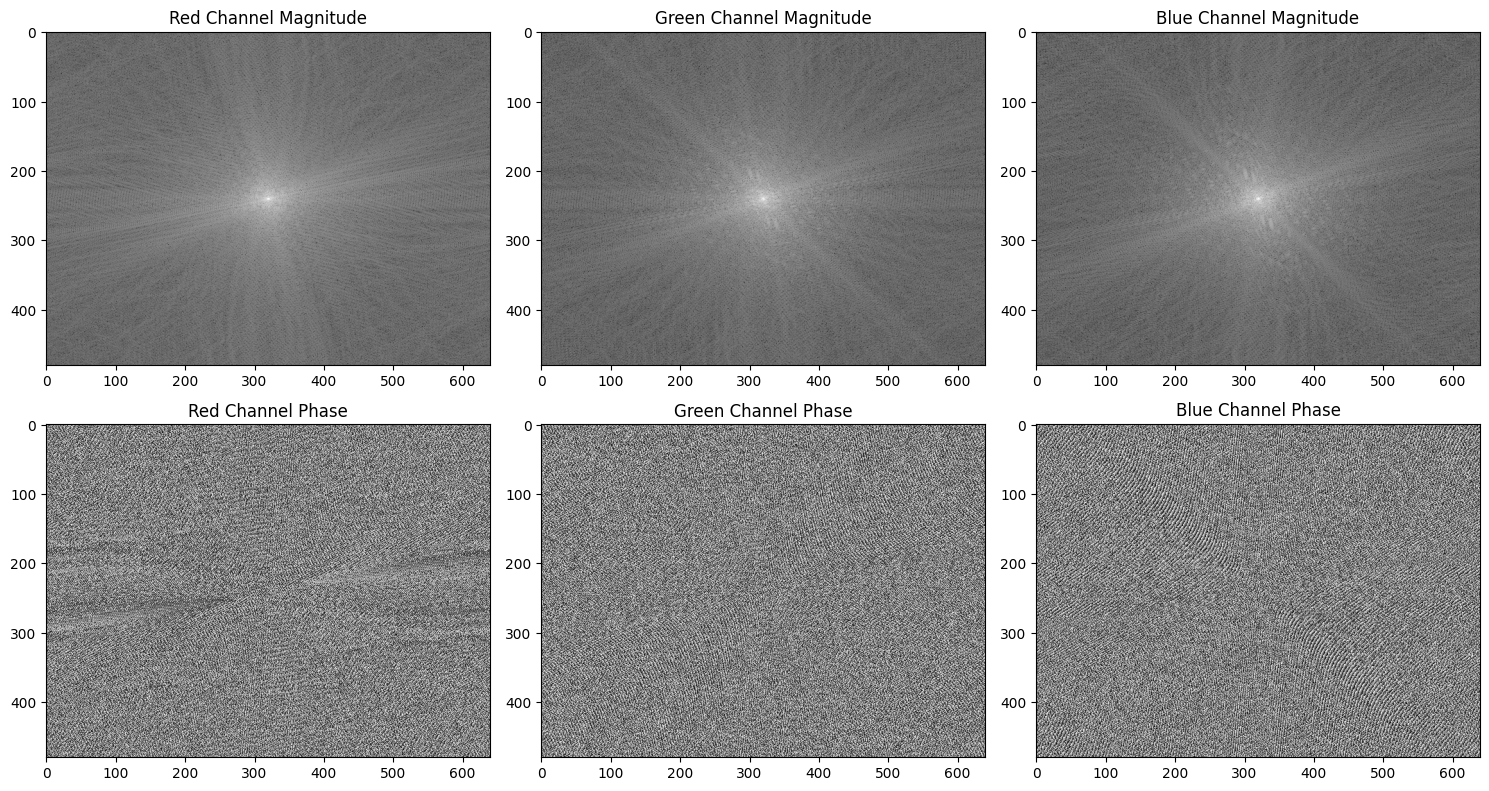

In [41]:
def showSpectrum(path, palette=None): # Widmo czestotliwosciowe obrazu
    """Display frequency spectrum for PNG images based on color type"""
    orig_img = Image.open(path)
    color_type = IHDR["color_type"]
    
    plt.figure(figsize=(15, 8))
    
    # obraz czarno-bialy
    if color_type == 0:
        grayscale_img = orig_img.convert('L')
        mag_spectrum, phase_spectrum = getMagnitudeSpectrum(np.array(grayscale_img))
        
        plt.subplot(1, 2, 1)
        plt.imshow(mag_spectrum, cmap='gray') # widmo amplitudy w skali szarosci 
        plt.title("Magnitude Spectrum")
        
        plt.subplot(1, 2, 2)
        plt.imshow(phase_spectrum, cmap='gray') # widmo fazy w skali szarosci
        plt.title("Phase Spectrum")
    
    # Kolory RGB
    elif color_type == 2:
        img_array = np.array(orig_img)
        
        for i, (color, channel) in enumerate(zip(['Red', 'Green', 'Blue'], np.rollaxis(img_array, -1))):
            mag, phase = getMagnitudeSpectrum(channel)
            
            plt.subplot(2, 3, i+1)
            plt.imshow(mag, cmap='gray')
            plt.title(f"{color} Channel Magnitude")
            
            plt.subplot(2, 3, i+4)
            plt.imshow(phase, cmap='gray')
            plt.title(f"{color} Channel Phase")
    
    # Indexed color - kolory z palety
    elif color_type == 3 and palette is not None:
        img_array = np.array(orig_img)
        palette_rgb = np.array(palette, dtype=np.uint8).reshape(-1, 3)
        rgb_array = palette_rgb[img_array] # zamienia każdy indeks na odpowiadający mu kolor RGB
        
        for i, (color, channel) in enumerate(zip(['Red', 'Green', 'Blue'], np.rollaxis(rgb_array, -1))):
            mag, phase = getMagnitudeSpectrum(channel)
            
            plt.subplot(2, 3, i+1)
            plt.imshow(mag, cmap='gray')
            plt.title(f"{color} Channel Magnitude")
            
            plt.subplot(2, 3, i+4)
            plt.imshow(phase, cmap='gray')
            plt.title(f"{color} Channel Phase")
    
    # Grayscale with alpha
    elif color_type == 4:
        img_array = np.array(orig_img)
        grayscale = img_array[:, :, 0]  # Bierzemy tylko grayscale
        
        mag, phase = getMagnitudeSpectrum(grayscale)
        
        plt.subplot(1, 2, 1)
        plt.imshow(mag, cmap='gray')
        plt.title("Grayscale Magnitude Spectrum")
        
        plt.subplot(1, 2, 2)
        plt.imshow(phase, cmap='gray')
        plt.title("Grayscale Phase Spectrum")
    
    # Truecolor with alpha
    elif color_type == 6:
        img_array = np.array(orig_img)
        
        for i, (color, channel) in enumerate(zip(['Red', 'Green', 'Blue'], np.rollaxis(img_array[:, :, :3], -1))):
            mag, phase = getMagnitudeSpectrum(channel)
            
            plt.subplot(2, 3, i+1)
            plt.imshow(mag, cmap='gray')
            plt.title(f"{color} Channel Magnitude")
            
            plt.subplot(2, 3, i+4)
            plt.imshow(phase, cmap='gray')
            plt.title(f"{color} Channel Phase")
    
    plt.tight_layout()
    plt.show()

def getMagnitudeSpectrum(image_data):
    """Calculate magnitude and phase spectrum of an image"""
    f = np.fft.fft2(image_data) # transformata fouriera obrazu 
    fshift = np.fft.fftshift(f) # przesunięcie środka spectrum do srodka obrazu
    magnitude = 20 * np.log(np.abs(fshift) + 1e-10) # magnituda
    phase = np.angle(fshift) # faza
    return magnitude, phase

showSpectrum("png.png")

## Źródła

- http://www.libpng.org/pub/png/spec/1.2/PNG-Structure.html